In [50]:
%load_ext autoreload
%autoreload 2

import gudhi
import numpy as np

from functions.data_loading import get_filtered_data_range, get_data_range, get_flight_persistence, get_removed_outliers
from functions.data_filtering import filter_by_bools, filter_flights
from functions.objects import PersistenceData

from tqdm import tqdm
from traffic.core import Traffic, Flight
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
origin = "oslo"
destination = "bergen"

#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
file_name = "oslo-bergen-2023-01-01-2024-01-01.pkl"
#filtered_flights, file_name = get_filtered_data_range(None, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/oslo-bergen-2023-01-01-2024-01-01.pkl"
trees, paths, file_name = get_flight_persistence(None, file_name, load_results=True)

distance_based_clusterings = {}
normal_clusterings = {}

In [52]:
pers_data = PersistenceData(trees, paths, "LL")

In [53]:
condensed_distance_matrix = []

for i in tqdm(range(len(trees))):
    for j in range(i+1, len(trees)):
        tree_i = trees[i]
        tree_j = trees[j]
        dist = gudhi.bottleneck_distance(tree_i, tree_j, 0.0001)
        condensed_distance_matrix.append(dist)
distance_matrix = squareform(condensed_distance_matrix)

100%|██████████| 6948/6948 [00:37<00:00, 187.43it/s] 


In [54]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import sys
sys.setrecursionlimit(10000)

Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

clustering = fcluster(Z, t=1.1, criterion='inconsistent', depth=2)

distance_based_clusterings["LINKAGE"] = clustering

In [55]:
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from collections import Counter

dbscan = DBSCAN(eps=0.00025, min_samples=3, metric="precomputed")
optics = OPTICS(metric="precomputed")

for cluster_method in [dbscan, optics]:
    method_name = cluster_method.__str__().split("(")[0]
    clustering = cluster_method.fit_predict(distance_matrix)
    distance_based_clusterings[method_name] = clustering

In [56]:
for key, clustering in distance_based_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Linkage:
1: 3 | 2: 7 | 3: 2 | 4: 2 | 5: 4 | 6: 3 | 7: 3 | 8: 2 | 9: 3 | 10: 6887 | 11: 14 | 12: 2 | 13: 2 | 14: 2 | 15: 3 | 16: 1 | 17: 8
Dbscan:
-1: 32 | 0: 6889 | 1: 10 | 2: 5 | 3: 6 | 4: 3 | 5: 3
Optics:
-1: 30 | 0: 6875 | 1: 10 | 2: 5 | 3: 11 | 4: 6 | 5: 11


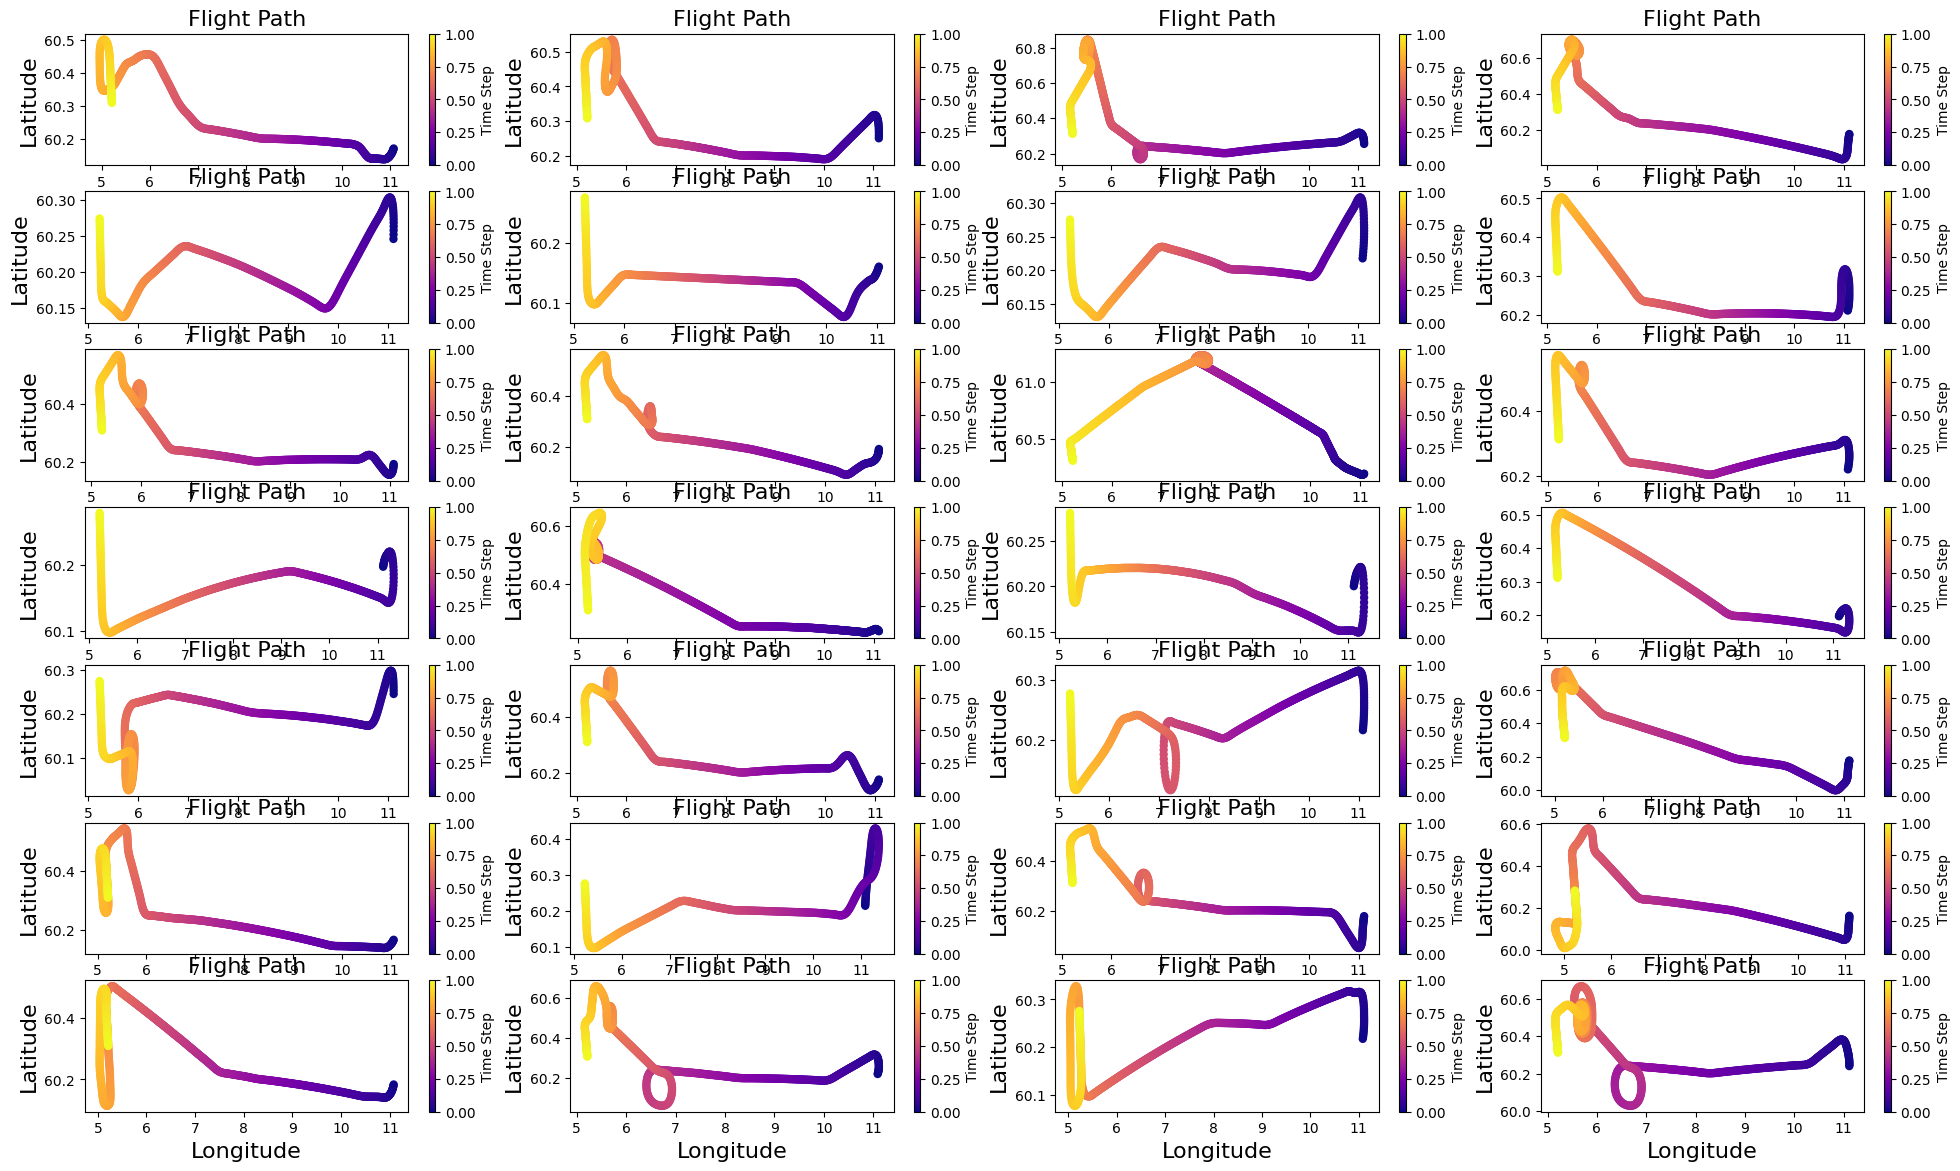

In [57]:
cluster_methods = ["LINKAGE", "DBSCAN", "OPTICS"]
sample_count = 4
method = cluster_methods[2]


clustering = distance_based_clusterings[method]
cluster_ids = np.unique(clustering)
fig, axs = plt.subplots(cluster_ids.shape[0], sample_count, figsize=(6 * sample_count, 2*cluster_ids.shape[0]))
for i, cluster_id in enumerate(cluster_ids):
    cluster = np.where(clustering == cluster_id)[0]
    samples = np.random.choice(cluster, size=min(sample_count, len(cluster)), replace=False)
    
    if sample_count == 1:
        pers_data.plot_raw_path(axs[i], samples[0])
    else:
        for j, sample in enumerate(samples):
            pers_data.plot_raw_path(axs[i, j], sample)

In [63]:
dbscan = DBSCAN(eps=0.0005, min_samples=2)
K_Means = KMeans(n_clusters=5)
optics = OPTICS()

data = pers_data.stats

normalizer = preprocessing.StandardScaler()
data = normalizer.fit_transform(data)

for cluster_method in [dbscan, optics, K_Means]:
    method_name = cluster_method.__str__().split("(")[0]
    clustering = cluster_method.fit_predict(data)
    normal_clusterings[method_name] = clustering

In [64]:
for key, clustering in normal_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Dbscan:
-1: 93 | 0: 6855
Optics:
-1: 75 | 0: 6859 | 1: 9 | 2: 5
Kmeans:
0: 6893 | 1: 5 | 2: 41 | 3: 1 | 4: 8


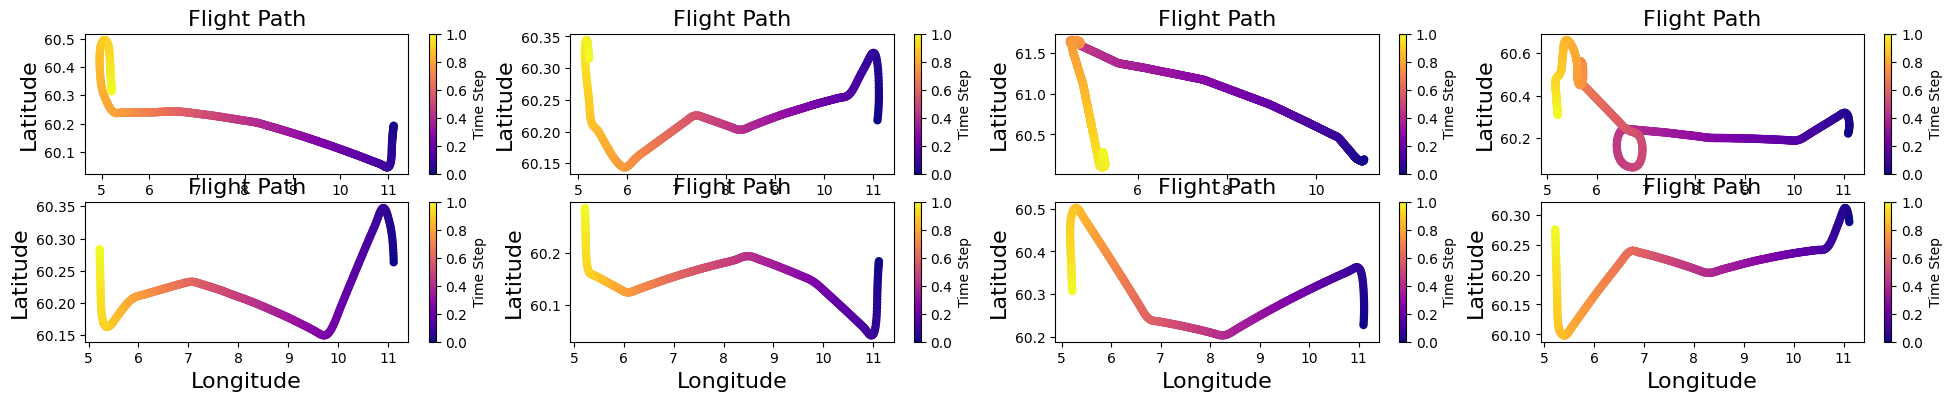

In [65]:
cluster_methods = ["DBSCAN", "OPTICS", "KMeans"]
sample_count = 4
method = cluster_methods[0]


clustering = normal_clusterings[method]
cluster_ids = np.unique(clustering)
fig, axs = plt.subplots(cluster_ids.shape[0], sample_count, figsize=(6 * sample_count, 2*cluster_ids.shape[0]))
for i, cluster_id in enumerate(cluster_ids):
    cluster = np.where(clustering == cluster_id)[0]
    samples = np.random.choice(cluster, size=min(sample_count, len(cluster)), replace=False)
    
    if sample_count == 1:
        pers_data.plot_raw_path(axs[i], samples[0])
    else:
        for j, sample in enumerate(samples):
            pers_data.plot_raw_path(axs[i, j], sample)